## Overview
This notebook is intended to be used with a pair of MDACs connected to a QT fridge in order to check all the lines for opens/shorts/continuity (i.e. things to check when the die is first loaded into the loader at room temperature and once it is cold).  It also some examples of using the MDAC as a breakout box.

Note that the code is written for a Keithley 2614b source-meter and assumes that you are using SMU channel A with the first MDAC (i.e. MDAC connected to lines 1-48) and SMU channel B connected to the second MDAC (e.g. lines 49-96).  In addition, it is assumed that you have used a grounding plug to ground the 'low' side of the SMU outputs while the 'high' side of the output is connected to the corresponding bus pin on the MDACs.

## Imports

In [1]:
import qcodes as qc
import numpy as np
from matplotlib import pyplot as plt
import logging
import matplotlib.pyplot as plt
import time

from qcodes.instrument_drivers.tektronix.Keithley_2600_channels import Keithley_2600
from StationQ.MDAC.Driver.MDAC import MDAC

from v0_utils.qcodes_tools import \
instrument_factory


In [2]:
station = qc.Station()

mdac1 = instrument_factory(
    MDAC, "mdac1", address='ASRL5::INSTR')
station.add_component(mdac1)

mdac2 = instrument_factory(
    MDAC, "mdac2", address='ASRL7::INSTR')
station.add_component(mdac2)

keithley = instrument_factory(Keithley_2600, "keithley", address='TCPIP::169.254.0.1')
station.add_component(keithley)

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\ctwrapper\functions.py:1649: VisaIOWarning: VI_WARN_NSUP_ATTR_STATE (1073676420): Although the specified state of the attribute is valid, it is not supported by this implementation.
  return library.viSetAttribute(session, attribute, attribute_state)


Connected to: QNL Sydney MDAC (serial:0x303035313535510D0031001D, firmware:1.4) in 4.95s
Connected to: QNL Sydney MDAC (serial:0x303035313535510D0032001D, firmware:1.4) in 5.30s
Connected to: Keithley Instruments Inc. 2614B (serial:4345881, firmware:3.2.2) in 0.05s


'keithley'

In [12]:
def setup_smu(SMU):
    SMU.smua.mode('voltage')
    SMU.smub.mode('voltage')
    SMU.smua.limiti(0.00001)
    SMU.smub.limiti(0.00001)
    SMU.smua.sourcerange_v(0.2)
    SMU.smub.sourcerange_v(0.2)
    SMU.smua.volt(0.01)
    SMU.smub.volt(0.01)
    SMU.smua.output('on')
    SMU.smub.output('on')

In [4]:
def setup_mdac(mdac1, mdac2):
    for ch in mdac1.channels:
        ch.voltage(0)
        ch.dac_output('open')
        
    
    for ch in mdac2.channels:
        ch.voltage(0)
        ch.dac_output('open')
        
        
    for ch in mdac1.channels:
        ch.gnd('close')
        ch.microd('close')
        
    for ch in mdac2.channels:
        ch.gnd('close')
        ch.microd('close')
    
    mdac1.bus('close')
    mdac2.bus('close')
        

        
def measure_continuity(mdac1, mdac2, SMU, Navg):
    R = np.empty(128)
    j = 0
    for ch in mdac1.channels:
        ch.bus('close')
        ch.gnd('open')
        
        r = 0 
        for i in range(Navg):
            r += SMU.smua.res()
            time.sleep(0.01)
        r = r/Navg #Average the resistance readings
        R[j] = r
        j += 1
        
        ch.gnd('close')
        ch.bus('open')
    
    print('Done with mdac1')    
    
    for ch in mdac2.channels:
#         print(ch)
        ch.bus('close')
        ch.gnd('open')
        
        r = 0 
        for i in range(Navg):
            r += SMU.smub.res()
            time.sleep(0.01)
        r = r/Navg #Average the resistance readings
        R[j] = r
        j += 1
        
        ch.gnd('close')
        ch.bus('open')
    
    print('Done with mdac2')
    
    return R

def mdac_cleanup(mdac1, mdac2):
    for ch in mdac1.channels:
        ch.microd('open')
        ch.gnd('open')
        ch.filter(1)
        
    for ch in mdac2.channels:
        ch.microd('open')
        ch.gnd('open')
        ch.filter(1)

In [5]:
t0 = time.time()
setup_smu(station.keithley)
setup_mdac(station.mdac1, station.mdac2)
R = measure_continuity(station.mdac1, station.mdac2, station.keithley, 10)
mdac_cleanup(station.mdac1, station.mdac2)
print('Total continuity check time = ' + str(time.time() - t0) + 's')

Done with mdac1
Done with mdac2
Total continuity check time = 100.3970594406128s


<IPython.core.display.Javascript object>


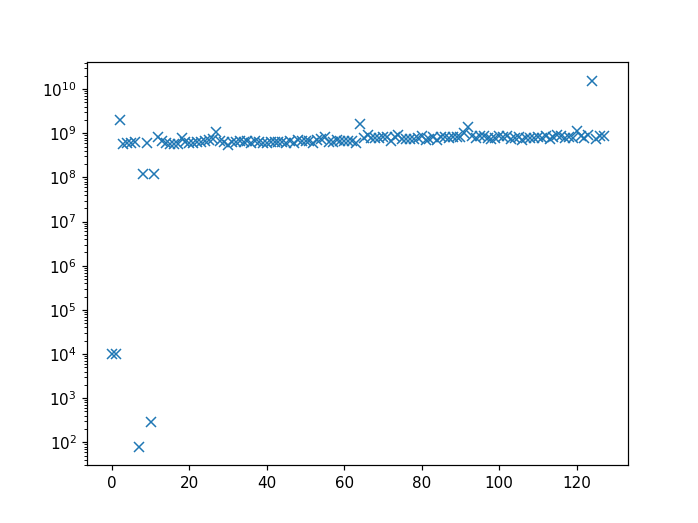

In [6]:
%matplotlib notebook
plt.semilogy(R, 'x')
# plt.ylim([0, 1e7])
plt.show()

In [31]:
R

array([  1.01134000e+04,   1.01148100e+04,   1.11010000e+06,
         1.12276100e+06,   9.83698900e+05,   9.53468800e+05,
         1.00071960e+06,   8.06710300e+01,   9.95992400e+05,
         1.03276770e+06,   2.94072800e+02,   1.03271630e+06,
         1.02699560e+06,   1.04338150e+06,   1.03099190e+06,
         1.25340700e+06,   1.24886800e+06,   1.22236700e+06,
         1.22778400e+06,   1.20737200e+06,   1.29203900e+06,
         1.16962200e+06,   1.21637500e+06,   1.16661700e+06,
         1.12921100e+06,   1.16508400e+06,   1.12006800e+06,
         1.02523440e+06,   1.16252700e+06,   1.22687600e+06,
         1.11628400e+06,   1.12387700e+06,   1.08084000e+06,
         1.01124540e+06,   1.02176860e+06,   9.95553900e+05,
         9.79238200e+05,   1.00743810e+06,   1.00330430e+06,
         1.04569800e+06,   1.01054560e+06,   1.03764240e+06,
         9.34253000e+05,   9.59682300e+05,   1.00109090e+06,
         9.63391100e+05,   9.88457600e+05,   9.17946500e+05,
         9.22329500e+05,